In [1]:
# Kevin Jesús Banda Azogil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import csv
import random
from IPython.display import display, Markdown
from numba import njit, prange


## Funciones y elementos comunes a todos:

In [2]:
# Colores ANSI para resaltar texto
RED = "\033[91m"
CYAN = "\033[96m"
GREEN = "\033[92m"
RESET = "\033[0m"

# Orden deseado de los archivos
NombreArchivos = ["DataSets/tai25b.dat", "DataSets/sko90b.dat", "DataSets/tai150b.dat"]
# Costos mínimos de referencia
CostoSoluciones = {
    "DataSets/tai25b.dat": 344355646,
    "DataSets/sko90b.dat": 115534,
    "DataSets/tai150b.dat": 498896643
}

semillas = [769123, 8435, 423543, 656343, 80987]


In [3]:

def leer_archivo_y_extraer_matrices(nombre_archivo):
    with open(nombre_archivo, "r") as f:
        # Leer la primera línea para obtener `n`
        n = int(f.readline().strip())  

        # Leer el resto del archivo con np.loadtxt
        datos = np.loadtxt(f, dtype=int)

    # Dividir los datos en dos matrices
    distancia = datos[:n, :n]  # Primera parte de la matriz
    flujo = datos[n:, :n]      # Segunda parte de la matriz

    return distancia, flujo, n


# Mostrar matriz (sin cambios)
def mostrar_matriz(nombre, matriz):
    print(f"Matriz {nombre}:")
    print("\n".join(" ".join(map(str, fila)) for fila in matriz))
    print()


# Cálculo del costo usando NumPy para evitar bucles anidados
@njit
def calcular_costo(solucion, distancia, flujo, n):
    costo = 0
    for i in prange(n):
        si = solucion[i]
        for j in range(n):
            sj = solucion[j]
            costo += distancia[i][j] * flujo[si][sj]
    return costo

@njit
def calcular_costo_swap(solucion, distancia, flujo, n, i, j, costo_actual):
    si = solucion[i]
    sj = solucion[j]
    delta = 0

    for k in range(n):
        if k != i and k != j:
            sk = solucion[k]

            delta += (
                (distancia[i][k] - distancia[j][k]) * (flujo[sj][sk] - flujo[si][sk]) +
                (distancia[k][i] - distancia[k][j]) * (flujo[sk][sj] - flujo[sk][si])
            )
    
    # Diagonales y cruzados
    delta += (distancia[i][i] - distancia[j][j]) * (flujo[sj][sj] - flujo[si][si])
    delta += (distancia[i][j] - distancia[j][i]) * (flujo[sj][si] - flujo[si][sj])

    return costo_actual + delta


## Algoritmos:
Greedy:

In [4]:
# Kevin Jesús Banda Azogil

def greedy_qap(distancia, flujo, n):
    ev=0
    potencialFlujo = []
    potencialDistancia = []

    #Calculo del potencial de distancia
    for j in range(n):
        potencialDistancia.append([sum(distancia[j]),j])
    potencialDistancia.sort(reverse=False, key=lambda x: x[0]) #De menor a mayor

    #Calculo del potencial de flujo
    for i in range(n):
        potencialFlujo.append([sum(flujo[i]),i])
    potencialFlujo.sort(reverse=True, key=lambda x: x[0]) #De mayor a menor
   
    asignaciones = [] # [unidad, localizacion]

    for i in range(n):
        asignaciones.append([potencialFlujo[i][1],potencialDistancia[i][1]])

    asignaciones.sort(reverse=False, key=lambda x: x[0])
    resultado = [subarray[1] for subarray in asignaciones]

    return resultado, calcular_costo(resultado, distancia, flujo, n), (ev+1)


Algoritmo Genético Básico:

In [5]:
def algoritmo_genetico_basico(distancia, flujo, n, semilla, generaciones=None):
    np.random.seed(semilla)
    random.seed(semilla)

    # POBLACION INICIAL
    # Se usa un esquema de poblacion ESTACIONARIA (solo se reemplazan algunos individuos por generacion)
    # Para hacerlo GENERACIONAL, se deberia guardar todos los hijos y seleccionar los mejores al final
    tam_poblacion = 50 # Valor razonable entre 30 y 200, balance entre diversidad y eficiencia

    if generaciones is None: 
        generaciones = 5000  # Numero de generaciones por defecto

    prob_cruce = 0.9  # Probabilidad de aplicar cruce
    tam_torneo = max(2, int(0.1 * tam_poblacion))  # Tamanio del torneo para seleccion con 10% de la poblacion
    tam_mutacion = max(1, int(0.05 * n))  # MUTACION optN: 5% de longitud del cromosoma

    # Se genera la poblacion inicial de soluciones aleatorias
    poblacion = [np.random.permutation(n) for _ in range(tam_poblacion)]
    # Se calculan los costos de cada solucion
    costos = np.array([calcular_costo(ind, distancia, flujo, n) for ind in poblacion])
    
    
    historial_costos = [costos.min()]  # Se guarda el mejor costo inicial
    mejor_solucion = poblacion[np.argmin(costos)].copy()  # Mejor solucion encontrada
    mejor_costo = costos.min()
    evaluaciones = tam_poblacion  # Contador de evaluaciones de soluciones

    # Bucle principal de generaciones
    for _ in range(generaciones):
        # Seleccion de dos padres por torneo
        p1, p2 = seleccion_torneo(poblacion, costos, tam_torneo)

        hijos = []

        # Se decide si se hace cruce o mutacion
        if np.random.rand() < prob_cruce:
            # CRUCE OX: conserva un segmento del primer padre y completa con orden del segundo
            h1, h2 = cruce_OX(p1, p2), cruce_OX(p2, p1)
        else:
            # MUTACION optN: se reordena una subsecuencia circular aleatoria
            h1, h2 = mutar_optN_dos(p1.copy(), p2.copy(), tam_mutacion)
        hijos.extend([h1, h2])

        # REEMPLAZO ESTACIONARIO: solo si el hijo mejora al peor actual
        for hijo in hijos:
            costo_hijo = calcular_costo(hijo, distancia, flujo, n)
            evaluaciones += 1
            peor_idx = np.argmax(costos)  # Se busca el peor individuo
            if costo_hijo < costos[peor_idx]:
                # Si el hijo es mejor que el peor, lo reemplaza
                poblacion[peor_idx] = hijo
                costos[peor_idx] = costo_hijo
                # Se actualiza el mejor si corresponde
                if costo_hijo < mejor_costo:
                    mejor_costo = costo_hijo
                    mejor_solucion = hijo.copy()

        # Se guarda el mejor costo de esta generacion
        historial_costos.append(mejor_costo)

    # Se devuelve la mejor solucion encontrada, su costo, historial de costos y cantidad de evaluaciones
    return mejor_solucion, mejor_costo, historial_costos, evaluaciones


def seleccion_torneo(poblacion, costos, tam_torneo):
    # tam_torneo: numero de individuos q representan el x% de la poblacion
    # Se seleccionan aleatoriamente 'tam_torneo' individuos.
    indices = random.sample(range(len(poblacion)), tam_torneo)

    # Se escoge el mejor
    p1_idx = min(indices, key=lambda idx: costos[idx])  # Mejor del torneo
    indices.remove(p1_idx)
    # Se escoge como padre 2 el siguiente mejor individuo (sin reemplazo)
    p2_idx = min(indices, key=lambda idx: costos[idx])  # Segundo mejor

    return poblacion[p1_idx].copy(), poblacion[p2_idx].copy()


def cruce_OX(padre1, padre2):
    # CRUCE OX (Order Crossover) - ESTILO DE LOS APUNTES
    n = len(padre1)
    ini, fin = sorted(random.sample(range(n), 2)) # Se elige un segmento aleatorio
    hijo = [-1] * n  # Inicializa el hijo con valores vacios

    segmento = set()
    # Se copia un segmento del primer padre respetando la poblacion
    for i in range(ini, fin):
        hijo[i] = padre1[i]
        segmento.add(padre1[i]) # Se guarda el contenido para evitar duplicados


    # Se completa el hijo con los elementos del segundo padre en orden (Sin repetir)
    idx_padre2 = 0
    for i in range(n):
        if hijo[i] == -1:
            while padre2[idx_padre2] in segmento: # Avanzamos mientras q el elemento del padre2 sea el q ha dado el padre1
                idx_padre2 += 1
            hijo[i] = padre2[idx_padre2]
            idx_padre2 += 1

    return np.array(hijo)


def mutar_optN_dos(padre1, padre2, tam):
    # Cada hijo tiene una mutacion no relacionada
    # Realiza una mutacion circular por reordenamiento de subsecuencia en dos padres
    
    n = len(padre1)
    inicio = random.randint(0, n - 1) # punto de inicio aleatorio
    indices = [(inicio + i) % n for i in range(tam)]  # Indices de la subsecuencia circulares (por si la subsecuencia excede el final)

    # Se extraen las subsecuencias de los padres
    sub1 = [padre1[i] for i in indices]
    sub2 = [padre2[i] for i in indices]

    # Se mezclan aleatoriamente las subsecuencias
    random.shuffle(sub1)
    random.shuffle(sub2)

    # Se insertan las subsecuencias mutadas en los respectivos hijos
    hijo1 = padre1.copy()
    hijo2 = padre2.copy()
    for idx, i in enumerate(indices):
        hijo1[i] = sub1[idx]
        hijo2[i] = sub2[idx]

    return np.array(hijo1), np.array(hijo2)


Algoritmo Genético CHC

In [6]:
def algoritmo_CHC(distancia, flujo, n, semilla, generaciones=None):
    np.random.seed(semilla)
    random.seed(semilla)
    
    tam_poblacion = 50  # Tamanio fijo de la poblacion

    if generaciones is None: 
        generaciones = 5000  # Numero de generaciones por defecto
    
    poblacion = [np.random.permutation(n) for _ in range(tam_poblacion)]  # Poblacion inicial de permutaciones aleatorias
    costos = np.array([calcular_costo(ind, distancia, flujo, n) for ind in poblacion])  # Evaluacion inicial de cada individuo
    
    evaluaciones = tam_poblacion
    historial_costos = [costos.min()]  # Guarda el mejor costo por generacion
    mejor_solucion = poblacion[np.argmin(costos)].copy()
    mejor_costo = costos.min()

    # Umbral de Hamming: solo se cruzan padres con diferencia significativa
    umbral = n // 4 

    # Historiales para analisis
    mejores_fit = []
    promedios_fit = []
    peores_fit = []
    diversidad = []
    reinicios = 0  # Contador de reinicios de poblacion

    # Bucle principal de generaciones
    for _ in range(generaciones):
        hijos = []

        # Generar hijos cruzando parejas si cumplen el umbral de Hamming
        for i in range(0, len(poblacion), 2):
            p1, p2 = poblacion[i], poblacion[(i + 1) % len(poblacion)] # evitamos indices fuera de rango usando el modulo

            # Si la distancia de Hamming entre padres > umbral, se cruzan
            h1, h2 = generar_descendencia_CHC(p1, p2, umbral)

            if h1 is not None: # Si no son nulos almacenamos los hijos
                hijos.append(h1)
                hijos.append(h2)


        mejora = False # Bandera para saber si hubo mejora en esta generación


        # Evaluar hijos y reemplazar si son mejores que el peor individuo
        for hijo in hijos:
            # Se calcula el costo (fitness) del hijo usando la función objetivo
            costo_hijo = calcular_costo(hijo, distancia, flujo, n)
            evaluaciones += 1

            # Se identifica el índice del peor individuo actual (el de mayor costo)
            peor_idx = np.argmax(costos)

            # Si el hijo es mejor (tiene menor costo) que el peor individuo
            if costo_hijo < costos[peor_idx]:
                poblacion[peor_idx] = hijo # Se reemplaza al peor individuo con el nuevo hijo
                costos[peor_idx] = costo_hijo # Se actualiza el valor de su costo en el vector de costos
                mejora = True # Se marca que hubo una mejora en esta generación

                # Si este hijo es mejor que el mejor encontrado hasta ahora
                if costo_hijo < mejor_costo: # Se actualiza la mejor solución global y su costo
                    mejor_costo = costo_hijo
                    mejor_solucion = hijo.copy()

        # Guardar mejor costo de la generación
        historial_costos.append(mejor_costo)

        # Guardar estadisticas de fitness y diversidad
        mejores_fit.append(costos.min())
        promedios_fit.append(costos.mean())
        peores_fit.append(costos.max())
        diversidad.append(calcular_diversidad(poblacion))

        # Si no hubo mejora, se reduce el umbral
        if not mejora:
            umbral -= 1
            if umbral < 0: # si el umbral llega a cero reiniciar poblacion
                umbral = n // 4  # Se reinicia el umbral
                reinicios += 1
                # Reiniciar población usando el mejor individuo como plantilla
                poblacion = reiniciar_poblacion(mejor_solucion, n, tam_poblacion)
                # Recalcular costos de la nueva población
                costos = np.array([calcular_costo(ind, distancia, flujo, n) for ind in poblacion])

    # Se devuelve la mejor solucion, su costo y los historiales
    return mejor_solucion, mejor_costo, historial_costos, evaluaciones, mejores_fit, promedios_fit, peores_fit, diversidad, reinicios



@njit
def distancia_hamming(p1, p2):
    # Calcula la distancia de Hamming entre dos permutaciones
    dist = 0
    for i in range(len(p1)):
        if p1[i] != p2[i]:
            dist += 1
    return dist


def generar_descendencia_CHC(p1, p2, umbral):
    # Si los padres son lo suficientemente diferentes, se cruzan
    if distancia_hamming(p1, p2) > umbral:
        return cruce_OX(p1, p2), cruce_OX(p2, p1)
    return None, None  # No se genera descendencia si no cumplen el umbral, es decir, se parecen demasiado


def reiniciar_poblacion(mejor, n, tam_poblacion):
    # Reinicia la poblacion partiendo del mejor individuo
    nueva_poblacion = [mejor.copy()]
    while len(nueva_poblacion) < tam_poblacion:
        perm = np.random.permutation(n) # Genera una permutacion aleatoria de los nmueros del 0 al n-1
        if not np.array_equal(perm, mejor):
            nueva_poblacion.append(perm)
    return nueva_poblacion


def calcular_diversidad(poblacion):
    # Calcula la diversidad promedio normalizada en la poblacion
    n = len(poblacion[0])
    total = 0 # Suma acumulada de distancias de Hamming entre todos los pares de individuos
    count = 0 # Número total de pares comparados

    for i in range(len(poblacion)):
        for j in range(i + 1, len(poblacion)):
            total += distancia_hamming(poblacion[i], poblacion[j])
            count += 1

    # Se divide por el total de comparaciones y por la longitud del cromosoma para normalizar
    return total / (count * n)  # Valor normalizado entre 0 y 1





Algoritmo Genético Multimodal

In [7]:
def algoritmo_genetico_clearing(distancia, flujo, n, semilla, generaciones=None):
    np.random.seed(semilla)
    random.seed(semilla)

    # Parametros del algoritmo
    tam_poblacion = 50
    if generaciones is None: generaciones = 5000
    prob_cruce = 0.9
    tam_torneo = max(2, int(0.1 * tam_poblacion))
    tam_mutacion = max(1, int(0.05 * n))

    # Parametros de clearing
    sigma_ratio = 0.2  # Proporcion del tamanio del individuo usada como umbral de similitud, tamaño del nicho
    sigma = int(sigma_ratio * n)  # Umbral de distancia de Hamming (definición de nicho)
    kappa = 1  # Numero maximo de ganadores por nicho

    # Inicializacion de la poblacion y sus costos
    poblacion = [np.random.permutation(n) for _ in range(tam_poblacion)]
    costos = np.array([calcular_costo(ind, distancia, flujo, n) for ind in poblacion])
    historial_costos = [costos.min()]
    mejor_solucion = poblacion[np.argmin(costos)].copy()
    mejor_costo = costos.min()
    evaluaciones = 0

    for _ in range(generaciones):
        # Se aplica el operador de clearing para mantener diversidad, reduce duplicados locales
        poblacion, costos = aplicar_clearing(poblacion, costos, sigma, kappa)

        # Seleccion de dos padres mediante torneo
        p1, p2 = seleccion_torneo(poblacion, costos, tam_torneo)

        # Se generan los hijos
        hijos = []
        if np.random.rand() < prob_cruce:
            h1, h2 = cruce_OX(p1, p2), cruce_OX(p2, p1)
        else:
            h1, h2 = mutar_optN_dos(p1.copy(), p2.copy(), tam_mutacion)
        hijos.extend([h1, h2])

        # Evaluacion e insercion de los hijos si son mejores que el peor actual
        for hijo in hijos:
            costo_hijo = calcular_costo(hijo, distancia, flujo, n)
            evaluaciones += 1
            peor_idx = np.argmax(costos)
            # comparacion con el peor
            if costo_hijo < costos[peor_idx]:
                poblacion[peor_idx] = hijo
                costos[peor_idx] = costo_hijo
                if costo_hijo < mejor_costo:# ver si es mejor que la solucion actual
                    mejor_costo = costo_hijo
                    mejor_solucion = hijo.copy()

        # Se guarda el mejor costo de esta generacion
        historial_costos.append(mejor_costo)

    # Se retorna la mejor solucion, su costo, el historial de mejoras y el total de evaluaciones
    return mejor_solucion, mejor_costo, historial_costos, evaluaciones



def aplicar_clearing(poblacion, costos, sigma, kappa=1):
    # Se convierten a arreglos de numpy para facilidad de manejo
    poblacion = np.array(poblacion)
    costos = np.array(costos)

    # Se ordena la poblacion por costo (de mejor a peor)
    orden = np.argsort(costos)
    poblacion = poblacion[orden]
    costos = costos[orden]

    eliminados = set()  # Indices que serán "eliminados" por estar demasiado cerca a un mejor individuo

    # Se recorre la poblacion para aplicar el operador de clearing
    for i in range(len(poblacion)):
        if i in eliminados:
            continue # Saltamos si ya fue eliminado

        num_ganadores = 1  # El mejor del nicho siempre se queda
        for j in range(i + 1, len(poblacion)):
            if j in eliminados:
                continue
            # Se calcula la distancia Hamming
            hamming = sum(g1 != g2 for g1, g2 in zip(poblacion[i], poblacion[j]))
            
            # Si está dentro del nicho y ya hay demasiados ganadores, se elimina
            if hamming < sigma:
                if num_ganadores < kappa:
                    num_ganadores += 1
                else:
                    eliminados.add(j)  # El individuo j es eliminado del nicho

    # Se filtran los individuos no eliminados
    nueva_poblacion = [ind for idx, ind in enumerate(poblacion) if idx not in eliminados]
    nuevos_costos = [cost for idx, cost in enumerate(costos) if idx not in eliminados]

    # Si hay menos individuos que el tamanio original, se rellenan con clones de los mejores
    while len(nueva_poblacion) < len(poblacion):
        idx = np.random.randint(len(nueva_poblacion))
        clone = nueva_poblacion[idx].copy()
        nueva_poblacion.append(clone)
        nuevos_costos.append(nuevos_costos[idx])  # Se usa el mismo costo que el original

    # Se retorna la nueva poblacion y sus costos
    return nueva_poblacion, nuevos_costos


In [8]:

def graficar_convergencia_CHC(mejores, promedios, peores, diversidad):
    generaciones = range(len(mejores))

    # Gráfico de fitness
    plt.figure(figsize=(10, 5))
    plt.plot(generaciones, mejores, label='Best Fitness', color='green')
    plt.plot(generaciones, promedios, label='Average Fitness', color='blue', linestyle='--')
    plt.plot(generaciones, peores, label='Worst Fitness', color='red', linestyle=':')
    plt.title('CHC Genetic Algorithm Convergence')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.legend()
    plt.grid(True)

    # Gráfico de diversidad genética
    plt.figure(figsize=(10, 5))
    plt.plot(generaciones, diversidad, label='Genetic Diversity', color='purple')
    plt.title('Genetic Diversity over Generations')
    plt.xlabel('Generación')
    plt.ylabel('Distancia de Hamming normalizada')
    plt.legend()
    plt.grid(True)

    plt.show()


In [9]:
# Contador de ejecuciones y almacenamiento en memoria
contador_algoritmos_ejecutados = 0
resultados_en_memoria = []
estadisticas_chc_por_dataset = {}  # Clave: nombre_archivo, Valor: dict con métricas y datos


# Crear encabezado del CSV sin historial de costos
def crear_encabezado_csv():
    with open("resultados_P2.csv", "w", newline="") as archivo_csv:
        escritor_csv = csv.writer(archivo_csv)
        escritor_csv.writerow([
            "Archivo", "Algoritmo", "Semilla", 
            "Costo", "Costo Optimo", "Evaluaciones"
        ])

# Escribir resultados en el CSV (sin historial), pero mantenerlo en memoria
def escribir_resultados(archivo, algoritmo, semilla, mejor_solucion, mejor_costo, costo_optimo, historial_costos, evaluaciones):
    global contador_algoritmos_ejecutados, resultados_en_memoria

    # Resultado completo para análisis en Jupyter
    fila_memoria = {
        "Archivo": archivo,
        "Algoritmo": algoritmo,
        "Semilla": semilla,
        "Mejor Solucion": mejor_solucion,
        "Costo": mejor_costo,
        "Costo Optimo": costo_optimo,
        "Historial de Costos": historial_costos,  # solo en memoria
        "Evaluaciones": evaluaciones
    }
    resultados_en_memoria.append(fila_memoria)

    # Resultado reducido para archivo CSV
    fila_csv = {
        "Archivo": archivo,
        "Algoritmo": algoritmo,
        "Semilla": semilla,
        "Costo": mejor_costo,
        "Costo Optimo": costo_optimo,
        "Evaluaciones": evaluaciones
    }

    with open("resultados_P2.csv", "a", newline="") as archivo_csv:
        escritor_csv = csv.DictWriter(archivo_csv, fieldnames=fila_csv.keys())
        escritor_csv.writerow(fila_csv)
        archivo_csv.flush()

    contador_algoritmos_ejecutados += 1


def ejecutar_algoritmos(nombre_archivo, distancia, flujo, n, semilla, costo_optimo):
    try:
        generaciones = None
        mejor_solucion, mejor_costo, historial_costos,ev = algoritmo_genetico_basico(distancia, flujo, n, semilla, generaciones=generaciones)
        escribir_resultados(nombre_archivo, "Algoritmo Genetico Basico", semilla, mejor_solucion, mejor_costo, costo_optimo, historial_costos, ev)

        mejor_solucion, mejor_costo, historial_costos,ev, mejores_fit_chc, promedios_fit_chc, peores_fit_chc, diversidad_chc, reinicios_chc = algoritmo_CHC(distancia, flujo, n, semilla, generaciones=generaciones)
        escribir_resultados(nombre_archivo, "Algoritmo Chc", semilla, mejor_solucion, mejor_costo, costo_optimo, historial_costos, ev)
        
        pintarPorChc=False
        if pintarPorChc:    
            print("Graficas chc - Dataset:",nombre_archivo,"- Semilla:", semilla, "- Reinicios:", reinicios_chc)
            graficar_convergencia_CHC(mejores_fit_chc, promedios_fit_chc, peores_fit_chc, diversidad_chc)

        # Guardar si es el mejor CHC para este dataset
        anterior = estadisticas_chc_por_dataset.get(nombre_archivo)
        if anterior is None or mejor_costo < anterior["Costo"]:
            estadisticas_chc_por_dataset[nombre_archivo] = {
                "Costo": mejor_costo,
                "Mejores": mejores_fit_chc,
                "Promedios": promedios_fit_chc,
                "Peores": peores_fit_chc,
                "Diversidad": diversidad_chc,
                "Reinicios": reinicios_chc,
                "Semilla": semilla
            }

        mejor_solucion, mejor_costo, historial_costos,ev = algoritmo_genetico_clearing(distancia, flujo, n, semilla, generaciones=generaciones)
        escribir_resultados(nombre_archivo, "Algoritmo Genetico Clearing", semilla, mejor_solucion, mejor_costo, costo_optimo, historial_costos, ev)


    except Exception as e:
        print(f"Ocurrió un error: {e}")


def graficar_mejores_chc_por_dataset():
    for dataset, datos in estadisticas_chc_por_dataset.items():
        print(f"\nGraficando CHC - Dataset: {dataset} - Semilla: {datos['Semilla']} - Reinicios: {datos['Reinicios']}")
        graficar_convergencia_CHC(
            datos["Mejores"],
            datos["Promedios"],
            datos["Peores"],
            datos["Diversidad"]
        )



Ejecucion de DataSets/tai25b.dat iniciada
Ejecucion de DataSets/tai25b.dat finalizada
Ejecucion de DataSets/sko90b.dat iniciada
Ejecucion de DataSets/sko90b.dat finalizada
Ejecucion de DataSets/tai150b.dat iniciada
Ejecucion de DataSets/tai150b.dat finalizada

Graficando CHC - Dataset: DataSets/tai25b.dat - Semilla: 769123 - Reinicios: 89


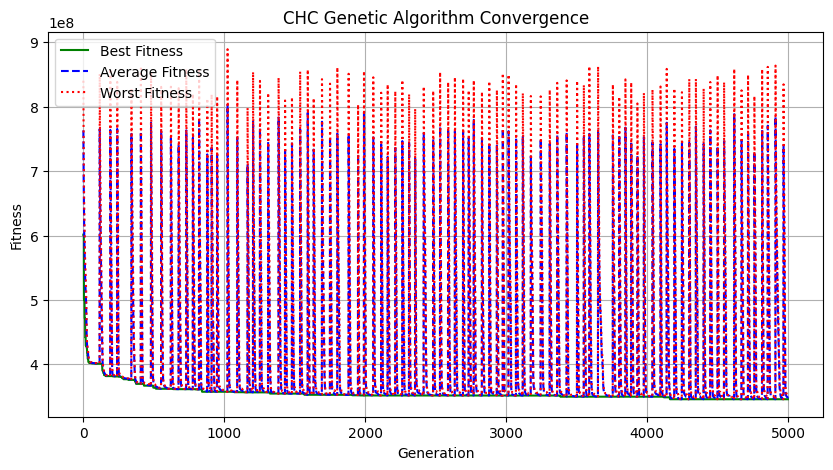

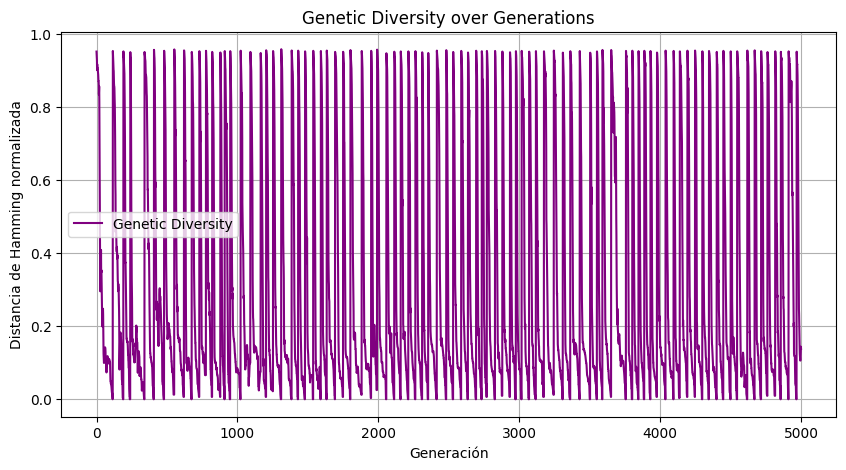


Graficando CHC - Dataset: DataSets/sko90b.dat - Semilla: 769123 - Reinicios: 43


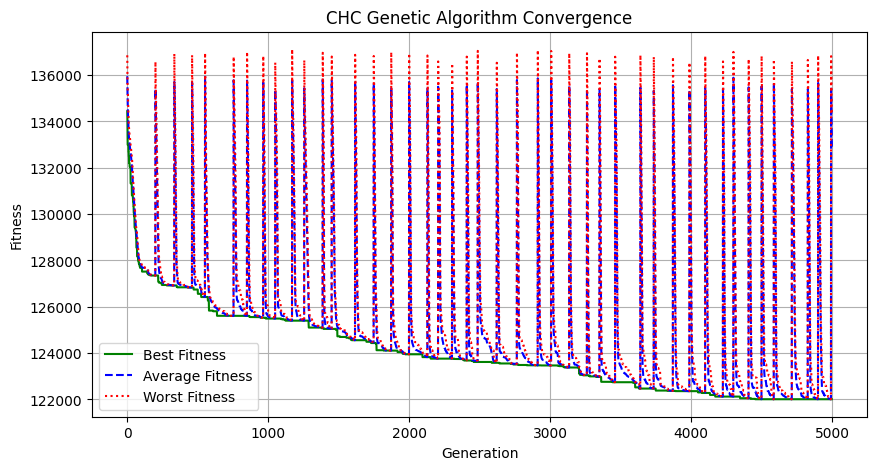

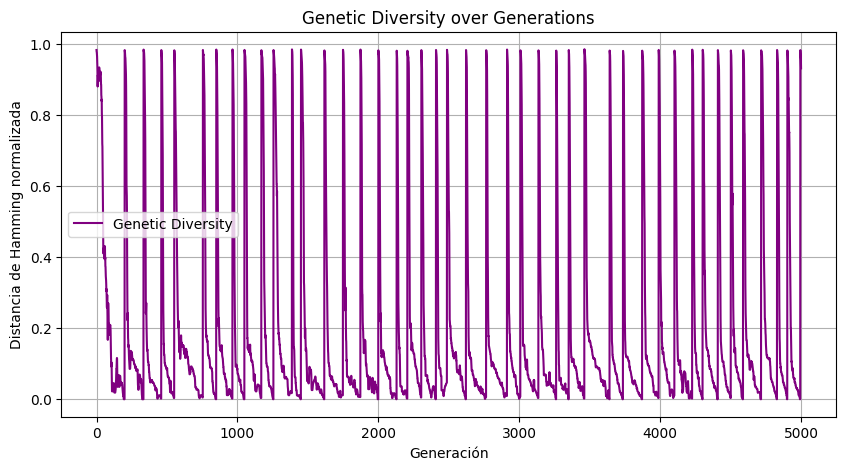


Graficando CHC - Dataset: DataSets/tai150b.dat - Semilla: 8435 - Reinicios: 30


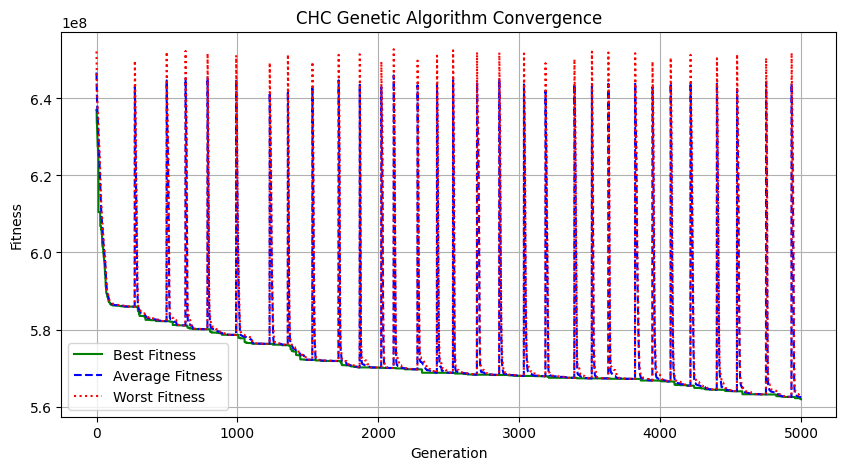

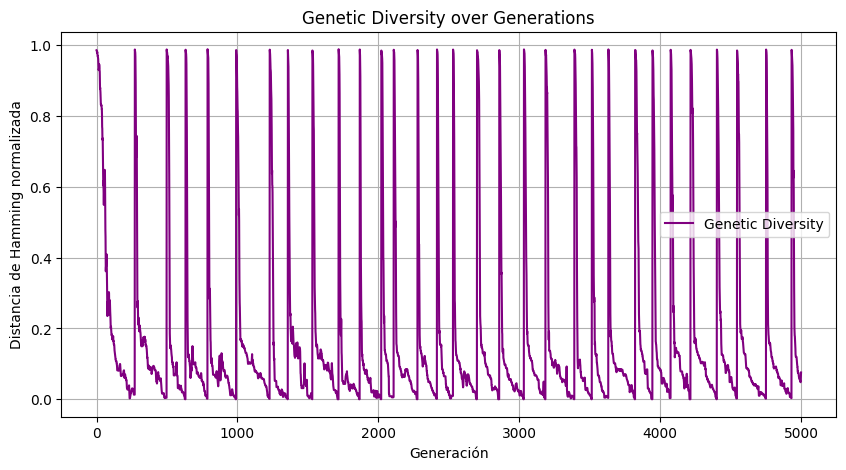

In [10]:

for i, nombre_archivo in enumerate(NombreArchivos):
    print(f"{GREEN}Ejecucion de {nombre_archivo} iniciada{RESET}")

    if i == 0:
        crear_encabezado_csv()

    distancia, flujo, n = leer_archivo_y_extraer_matrices(nombre_archivo)

    mejor_solucion, mejor_costo, evaluaciones = greedy_qap(distancia, flujo, n)
    escribir_resultados(nombre_archivo, "Greedy", "N/A", mejor_solucion, mejor_costo, CostoSoluciones[nombre_archivo], [], evaluaciones)

    
    for semilla in semillas:
        ejecutar_algoritmos(nombre_archivo, distancia, flujo, n, semilla, CostoSoluciones[nombre_archivo])

    print(f"{RED}Ejecucion de {nombre_archivo} finalizada{RESET}")


graficar_mejores_chc_por_dataset()

In [11]:
def formatear_numero(valor, decimales=0):
    if valor is None or valor == "-" or (isinstance(valor, float) and np.isnan(valor)):
        return "-"
    try:
        valor_num = float(valor)
    except (ValueError, TypeError):
        return str(valor)  # si no es numérico, devuelve tal cual
    
    s = f"{valor_num:,.{decimales}f}"
    s = s.replace(",", "X").replace(".", ",").replace("X", ".")
    return s



def leer_y_representar_resultados_desde_memoria(resultados, representarHistorial=True):
    df = pd.DataFrame(resultados)
    if df.empty:
        print("No hay resultados para mostrar.")
        return

    df["Semilla"] = df["Semilla"].apply(lambda x: int(x) if str(x).isdigit() else "N/A")
    df["Archivo"] = pd.Categorical(df["Archivo"], categories=NombreArchivos, ordered=True)
    df = df.sort_values(by=["Archivo", "Algoritmo", "Semilla"])

    for archivo in NombreArchivos:
        nombre_simple = archivo.split("/")[-1].replace(".dat", "")
        df_archivo = df[df["Archivo"] == archivo]
        if df_archivo.empty:
            continue

        display(Markdown(f"## 📁 Dataset: **{nombre_simple}**"))

        for algoritmo, grupo_alg in df_archivo.groupby("Algoritmo", sort=False):
            display(Markdown(f"### 🧬 Algoritmo: **{algoritmo}** - Dataset: **{nombre_simple}**"))

            # Construcción de la tabla tipo "Tabla 1.1"
            filas = []
            for _, fila in grupo_alg.iterrows():
                filas.append([
                    f"Semilla {fila['Semilla']}",
                    formatear_numero(fila["Costo"]),
                    formatear_numero(fila["Evaluaciones"])
                ])

            media_costo = grupo_alg["Costo"].mean()
            media_ev = grupo_alg["Evaluaciones"].mean()
            std_costo = grupo_alg["Costo"].std()
            std_ev = grupo_alg["Evaluaciones"].std()

            filas.append([
                "Media",
                formatear_numero(media_costo, 2),
                formatear_numero(media_ev, 2)
            ])
            filas.append([
                "Des.Tip. (σ)",
                formatear_numero(std_costo, 2),
                formatear_numero(std_ev, 2)
            ])
            
            tabla = pd.DataFrame(filas, columns=["Ejecución", "Costo", "#Evaluaciones"])
            display(tabla)


            # Gráfica
            hay_historial = any(
                isinstance(hist, list) and len(hist) > 0
                for hist in grupo_alg["Historial de Costos"]
            )

            if hay_historial and representarHistorial:
                display(Markdown(f"📈 **Evolución del Costo - {algoritmo}**"))
                plt.figure(figsize=(10, 5))
                for _, fila in grupo_alg.iterrows():
                    historial = fila["Historial de Costos"]
                    if isinstance(historial, list) and len(historial) > 0:
                        plt.plot(historial, label=f"Semilla {fila['Semilla']}")
                if archivo in CostoSoluciones:
                    plt.axhline(y=CostoSoluciones[archivo], color='red', linestyle='--', label=f"Costo Óptimo: {CostoSoluciones[archivo]}")
                plt.xlabel("Iteraciones")
                plt.ylabel("Costo")
                plt.title(f"{nombre_simple} - {algoritmo}")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()


In [12]:
df = pd.DataFrame(resultados_en_memoria)
print(df["Archivo"].unique())

leer_y_representar_resultados_desde_memoria(resultados_en_memoria, representarHistorial=False)


['DataSets/tai25b.dat' 'DataSets/sko90b.dat' 'DataSets/tai150b.dat']


## 📁 Dataset: **tai25b**

### 🧬 Algoritmo: **Algoritmo Chc** - Dataset: **tai25b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,353.036.884,102.216
1,Semilla 80987,356.008.717,101.182
2,Semilla 423543,366.741.332,101.098
3,Semilla 656343,349.612.999,103.990
4,Semilla 769123,345.869.372,100.616
5,Media,"354.253.860,80","101.820,40"
6,Des.Tip. (σ),"7.942.523,85","1.345,70"


### 🧬 Algoritmo: **Algoritmo Genetico Basico** - Dataset: **tai25b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,502.851.530,10.050
1,Semilla 80987,474.199.258,10.050
2,Semilla 423543,479.537.650,10.050
3,Semilla 656343,566.397.956,10.050
4,Semilla 769123,407.715.879,10.050
5,Media,"486.140.454,60","10.050,00"
6,Des.Tip. (σ),"57.133.899,38","0,00"


### 🧬 Algoritmo: **Algoritmo Genetico Clearing** - Dataset: **tai25b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,558.427.386,10.000
1,Semilla 80987,491.294.706,10.000
2,Semilla 423543,493.357.076,10.000
3,Semilla 656343,477.960.520,10.000
4,Semilla 769123,470.561.901,10.000
5,Media,"498.320.317,80","10.000,00"
6,Des.Tip. (σ),"34.899.511,84","0,00"


### 🧬 Algoritmo: **Greedy** - Dataset: **tai25b**

,Ejecución,Costo,#Evaluaciones
0,Semilla N/A,913.427.707,1
1,Media,"913.427.707,00","1,00"
2,Des.Tip. (σ),-,-


## 📁 Dataset: **sko90b**

### 🧬 Algoritmo: **Algoritmo Chc** - Dataset: **sko90b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,123.048,63.224
1,Semilla 80987,122.720,61.626
2,Semilla 423543,123.116,61.778
3,Semilla 656343,122.932,64.846
4,Semilla 769123,122.008,62.228
5,Media,"122.764,80","62.740,40"
6,Des.Tip. (σ),"448,96","1.332,11"


### 🧬 Algoritmo: **Algoritmo Genetico Basico** - Dataset: **sko90b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,125.706,10.050
1,Semilla 80987,127.768,10.050
2,Semilla 423543,126.032,10.050
3,Semilla 656343,125.626,10.050
4,Semilla 769123,126.128,10.050
5,Media,"126.252,00","10.050,00"
6,Des.Tip. (σ),"873,50","0,00"


### 🧬 Algoritmo: **Algoritmo Genetico Clearing** - Dataset: **sko90b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,126.048,10.000
1,Semilla 80987,124.950,10.000
2,Semilla 423543,125.902,10.000
3,Semilla 656343,126.208,10.000
4,Semilla 769123,124.674,10.000
5,Media,"125.556,40","10.000,00"
6,Des.Tip. (σ),"694,99","0,00"


### 🧬 Algoritmo: **Greedy** - Dataset: **sko90b**

,Ejecución,Costo,#Evaluaciones
0,Semilla N/A,136.080,1
1,Media,"136.080,00","1,00"
2,Des.Tip. (σ),-,-


## 📁 Dataset: **tai150b**

### 🧬 Algoritmo: **Algoritmo Chc** - Dataset: **tai150b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,561.902.317,51.938
1,Semilla 80987,563.064.372,53.390
2,Semilla 423543,565.055.129,51.472
3,Semilla 656343,565.188.592,53.820
4,Semilla 769123,567.246.571,51.058
5,Media,"564.491.396,20","52.335,60"
6,Des.Tip. (σ),"2.069.697,68","1.209,48"


### 🧬 Algoritmo: **Algoritmo Genetico Basico** - Dataset: **tai150b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,597.608.949,10.050
1,Semilla 80987,592.892.961,10.050
2,Semilla 423543,592.624.740,10.050
3,Semilla 656343,592.730.000,10.050
4,Semilla 769123,599.117.747,10.050
5,Media,"594.994.879,40","10.050,00"
6,Des.Tip. (σ),"3.122.366,79","0,00"


### 🧬 Algoritmo: **Algoritmo Genetico Clearing** - Dataset: **tai150b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,586.119.471,10.000
1,Semilla 80987,589.767.885,10.000
2,Semilla 423543,594.667.437,10.000
3,Semilla 656343,595.883.063,10.000
4,Semilla 769123,602.952.445,10.000
5,Media,"593.878.060,20","10.000,00"
6,Des.Tip. (σ),"6.404.624,46","0,00"


### 🧬 Algoritmo: **Greedy** - Dataset: **tai150b**

,Ejecución,Costo,#Evaluaciones
0,Semilla N/A,653.315.921,1
1,Media,"653.315.921,00","1,00"
2,Des.Tip. (σ),-,-


In [13]:

def tabla_resultados_globales(resultados, nombre_algoritmos=None):
    df = pd.DataFrame(resultados)
    if df.empty:
        print("No hay resultados para mostrar.")
        return

    df["Archivo"] = df["Archivo"].apply(lambda x: x.split("/")[-1].replace(".dat", ""))
    df["Costo"] = pd.to_numeric(df["Costo"], errors='coerce')

    if nombre_algoritmos is None:
        nombre_algoritmos = df["Algoritmo"].unique().tolist()

    nombre_algoritmos = [alg for alg in nombre_algoritmos if alg.lower() != "greedy"]


    modelos = ["Óptimo", "Greedy"] + nombre_algoritmos

    columnas = ["Mejor", "Media", "Peor", "σ"]


    for archivo in NombreArchivos:
        ds = archivo.split("/")[-1].replace(".dat", "")
        if ds not in df["Archivo"].values:
            continue
        # resto del código usando ds...

        tabla_resumen = pd.DataFrame(index=modelos, columns=columnas)
        
        display(Markdown(f"## 📁 Resumen: **{ds}**"))


        # Valor óptimo
        opt_val = CostoSoluciones.get(f"DataSets/{ds}.dat", "-")
        tabla_resumen.loc["Óptimo", "Media"] = formatear_numero(opt_val)
        tabla_resumen.loc["Óptimo", ["Mejor", "Peor", "σ"]] = "-"

        # Valor Greedy (único en Media, otros '-')
        greedy_subset = df[(df["Archivo"] == ds) & (df["Algoritmo"].str.lower() == "greedy")]
        if not greedy_subset.empty:
            media_greedy = greedy_subset["Costo"].mean()
            tabla_resumen.loc["Greedy", "Media"] = formatear_numero(media_greedy)
            tabla_resumen.loc["Greedy", ["Mejor", "Peor", "σ"]] = "-"
        else:
            tabla_resumen.loc["Greedy"] = "-"

        # Otros algoritmos
        for alg in nombre_algoritmos:
            if alg.lower() == "greedy":
                continue  # ya está tratado arriba

            subset = df[(df["Archivo"] == ds) & (df["Algoritmo"] == alg)]
            if subset.empty:
                tabla_resumen.loc[alg, :] = "-"
            else:
                tabla_resumen.loc[alg, "Mejor"] = formatear_numero(subset["Costo"].min())
                tabla_resumen.loc[alg, "Media"] = formatear_numero(subset["Costo"].mean(), 2)
                tabla_resumen.loc[alg, "Peor"] = formatear_numero(subset["Costo"].max())
                tabla_resumen.loc[alg, "σ"] = formatear_numero(subset["Costo"].std(), 2)

        display(tabla_resumen)


In [14]:
def graficar_coste_inicial_final_por_dataset(resultados_en_memoria, mostrar_todos=False):
    # Diccionario: { archivo: { algoritmo: lista de pares (inicio, fin) } }
    datos_por_dataset = {}

    for resultado in resultados_en_memoria:
        archivo = resultado["Archivo"]
        algoritmo = resultado["Algoritmo"]
        historial = resultado["Historial de Costos"]

        if historial and len(historial) > 1:
            if archivo not in datos_por_dataset:
                datos_por_dataset[archivo] = {}

            if algoritmo not in datos_por_dataset[archivo]:
                datos_por_dataset[archivo][algoritmo] = []

            if mostrar_todos:
                datos_por_dataset[archivo][algoritmo].append((historial[0], historial[-1]))
            else:
                if len(datos_por_dataset[archivo][algoritmo]) == 0:
                    datos_por_dataset[archivo][algoritmo].append((historial[0], historial[-1]))

    # Graficar una figura por cada dataset
    for archivo, algoritmos in datos_por_dataset.items():
        nombres_algoritmos = []
        costos_iniciales = []
        costos_finales = []

        for algoritmo, pares_costos in algoritmos.items():
            for i, (costo_ini, costo_fin) in enumerate(pares_costos):
                nombre = f"{algoritmo}" if not mostrar_todos else f"{algoritmo} ({i+1})"
                nombres_algoritmos.append(nombre)
                costos_iniciales.append(costo_ini)
                costos_finales.append(costo_fin)

        x = range(len(nombres_algoritmos))
        ancho_barra = 0.35

        plt.figure(figsize=(10, 5))
        plt.bar(x, costos_iniciales, width=ancho_barra, label="Costo Inicial", color="royalblue")
        plt.bar([i + ancho_barra for i in x], costos_finales, width=ancho_barra, label="Costo Final", color="mediumseagreen")

        plt.xlabel("Algoritmo")
        plt.ylabel("Costo")
        plt.title(f"Comparación de costos - Dataset: {archivo}")
        plt.xticks([i + ancho_barra / 2 for i in x], nombres_algoritmos, rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.show()



Tablas resumen globales



## 📁 Resumen: **tai25b**

,Mejor,Media,Peor,σ
Óptimo,-,344.355.646,-,-
Greedy,-,913.427.707,-,-
Algoritmo Genetico Basico,407.715.879,"486.140.454,60",566.397.956,"57.133.899,38"
Algoritmo Chc,345.869.372,"354.253.860,80",366.741.332,"7.942.523,85"
Algoritmo Genetico Clearing,470.561.901,"498.320.317,80",558.427.386,"34.899.511,84"


## 📁 Resumen: **sko90b**

,Mejor,Media,Peor,σ
Óptimo,-,115.534,-,-
Greedy,-,136.080,-,-
Algoritmo Genetico Basico,125.626,"126.252,00",127.768,"873,50"
Algoritmo Chc,122.008,"122.764,80",123.116,"448,96"
Algoritmo Genetico Clearing,124.674,"125.556,40",126.208,"694,99"


## 📁 Resumen: **tai150b**

,Mejor,Media,Peor,σ
Óptimo,-,498.896.643,-,-
Greedy,-,653.315.921,-,-
Algoritmo Genetico Basico,592.624.740,"594.994.879,40",599.117.747,"3.122.366,79"
Algoritmo Chc,561.902.317,"564.491.396,20",567.246.571,"2.069.697,68"
Algoritmo Genetico Clearing,586.119.471,"593.878.060,20",602.952.445,"6.404.624,46"


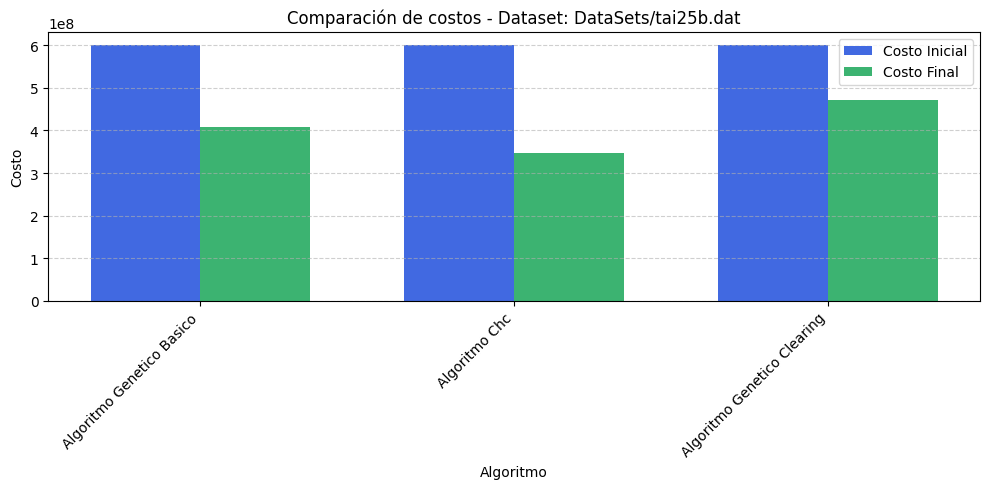

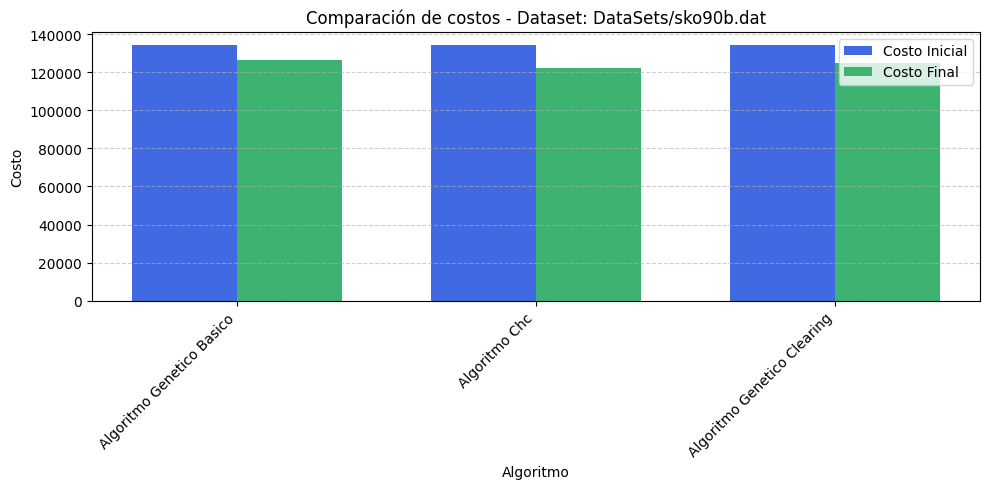

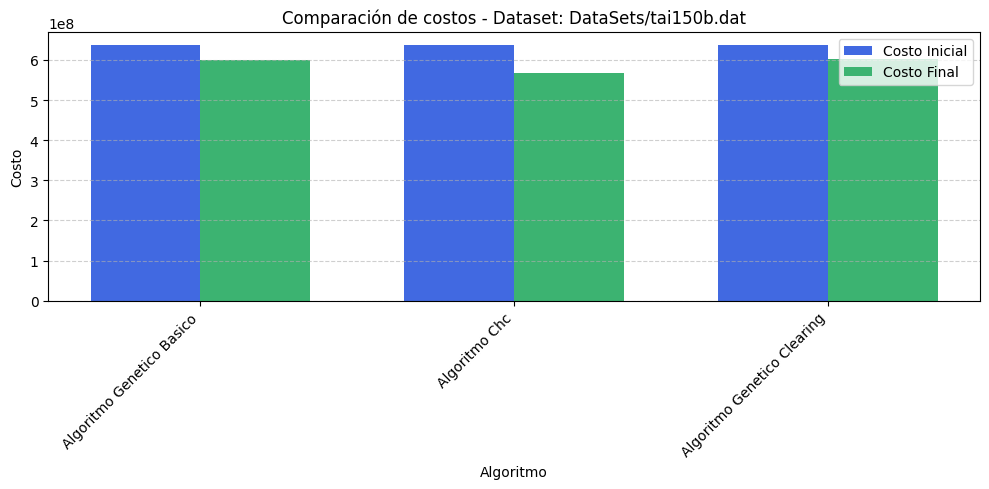

In [15]:
print("\nTablas resumen globales\n")
algoritmos_orden = ["Greedy", "Algoritmo Genetico Basico", "Algoritmo Chc", "Algoritmo Genetico Clearing"]  # Ajusta según nombres usados
tabla_resultados_globales(resultados_en_memoria, nombre_algoritmos=algoritmos_orden)
graficar_coste_inicial_final_por_dataset(resultados_en_memoria)
